# Espectros de variância, covariância e correlação

### Estudo dos intervalos de confiança

por [Afrânio](http://afrjr.weebly.com) - LMSCP - Laboratório de Modelagem, Simulação e Controle de Processos - PEQ/COPPE/UFRJ

10/2018

O objetivo deste notebook [Jupyter](http://jupyter.org/) é servir como compilação dos estudos iniciais sobre intervalos de confiança realizado no âmbito do projeto **spectra**, destinado a implementar em Python códigos para geração de espectros de variância, covariância e correlação, de acordo com as técnicas propostas por [FEITAL E PINTO, 2015](http://onlinelibrary.wiley.com/doi/10.1002/cjce.22219/abstract). A linguagem de programação utilizada é a [Python 3.6](https://www.python.org/).

Atenção: A classe **spectra** aqui implementada está totalmente funcional, mas pode não estar em sua última versão. Para a versão mais recente, checar o módulo *spectra.py* presente no repositório https://github.com/afraeq/spectra.

In [156]:
# importando todos os módulos necessários

import os
import numpy as np
import pandas as pd
from IPython.display import HTML
import matplotlib as mpl
import matplotlib.pyplot as plt
from matplotlib import animation
%matplotlib inline

In [147]:
# classe spectra

import numpy as np
import matplotlib.pyplot as plt

class spectra (object):

    #########################
    
    def __init__ (self,data):
               
        data = np.asarray(data)
            
        if data.ndim==1:
            self.data = data[:,np.newaxis]
        elif data.ndim==2:
                self.data = data
        else:
            raise ValueError('Entry must have 1 or 2 dimensions!')
        
        self.var_spctr   = {}
        self.cov_spctr   = {}
        self.corr_spctr  = {}
        self.l_var_spctr = {}
        
        self.jump_WS_var   = {}
        self.jump_WS_cov   = {}
        self.jump_WS_l_var = {}
        
        kinds = ['sliding','independent']
        
        for kind in kinds:       
            self.var_spctr   [kind] = {}
            self.cov_spctr   [kind] = {}
            self.corr_spctr  [kind] = {}
            self.l_var_spctr [kind] = {}

        self.spctr_size = {}            
        self.spctr_size['sliding']     = self.data.shape[0]+1
        self.spctr_size['independent'] = int(self.data.shape[0]/2+1)
        
        # https://stackoverflow.com/questions/39232790
        self.idx = lambda WS,d: \
        (d*np.arange((self.data.shape[0]-WS+1)/d)[:,None].astype(int) + \
        np.arange(WS))

        self.d = {}
        self.d['sliding']     = lambda WS: 1
        self.d['independent'] = lambda WS: WS
        
    #########################
                
    def calc_Var_Spectra (self, kind='sliding', jump_WS=1, 
                          percentiles=[25,50,75]):
        
        self.jump_WS_var[kind] = jump_WS
                
        spctr_size = self.spctr_size[kind]
                        
        var_spctr_mean = np.zeros((spctr_size,self.data.shape[1]))

        var_spctr_percentile = {}
        for i in percentiles:
            var_spctr_percentile[i] = np.zeros((spctr_size,self.data.shape[1]))
        
        for WS in range(2,spctr_size,jump_WS):
            win = self.data[self.idx(WS,self.d[kind](WS))]
            var = np.var(win,ddof=1,axis=1)
            var_spctr_mean[WS,:]   = np.mean(var,axis=0)
            for i in percentiles:
                var_spctr_percentile[i][WS,:] = np.percentile(var, i, axis=0)
                                
        self.var_spctr[kind]['mean']   = var_spctr_mean                                             
        for i in percentiles:
            self.var_spctr[kind][i] = var_spctr_percentile[i]
            
    ################################################ 
    
    def calc_Cov_Spectra (self, kind='sliding', jump_WS=1):
        
        self.jump_WS_cov[kind] = jump_WS
        
        spctr_size = self.spctr_size[kind]
        
        cov_spctr_mean  = np.zeros((spctr_size,self.data.shape[1],
                                    self.data.shape[1]))
        corr_spctr_mean = np.zeros((spctr_size,self.data.shape[1],
                                    self.data.shape[1]))
                
        # https://stackoverflow.com/questions/26089893
        # https://stackoverflow.com/questions/40394775
        
        for WS in range(2,spctr_size,jump_WS):  
            win = self.data[self.idx(WS,self.d[kind](WS))]
            m1 = win - win.sum(axis=1,keepdims=True)/win.shape[1]
            Sxx = np.einsum('ijk,ijl->ikl',m1,m1)/(win.shape[1] - 1)
            Sxx_mean = np.einsum('ijk->jk',Sxx)/win.shape[0]
            cov_spctr_mean[WS,:,:] = Sxx_mean
            Dinv = np.linalg.inv(np.diag(np.sqrt(np.diag(Sxx_mean))))
            corr_spctr_mean[WS,:,:] = Dinv@Sxx_mean@Dinv
            
        self.cov_spctr[kind]['mean']  = cov_spctr_mean
        self.corr_spctr[kind]['mean'] = corr_spctr_mean

    #########################   
    
    def calc_Lat_Var_Spectra (self, kind='sliding',jump_WS=1):
        
        self.jump_WS_l_var[kind] = jump_WS
        
        from sklearn.preprocessing import scale
        data = scale(self.data)

        spctr_size = self.spctr_size[kind]
        
        l_var_spctr_mean = np.zeros((spctr_size,data.shape[1]))
                
        for WS in range(data.shape[1],spctr_size,jump_WS):  
            win = data[self.idx(WS,self.d[kind](WS))]
            m1 = win - win.sum(axis=1,keepdims=True)/win.shape[1]
            Sxx = np.einsum('ijk,ijl->ikl',m1,m1)/(win.shape[1] - 1)
            Sxx_mean = np.einsum('ijk->jk',Sxx)/win.shape[0]
            _, L, _ = np.linalg.svd(Sxx_mean)
            l_var_spctr_mean[WS,:] = L
            
        self.l_var_spctr[kind]['mean'] = l_var_spctr_mean
        
    #########################   

    def plot_Var_Spectra(self,i=None,ax=None,
                         percentile='mean',conf_region=False):
        
        if i==None:
            i= np.arange(self.data.shape[1])
        if ax == None:
            ax = plt.gca() 
        if self.var_spctr['sliding']:
            ax.set_prop_cycle(None)
            ax.plot(np.arange(2,self.spctr_size['sliding'],
                              self.jump_WS_var['sliding']),
                    self.var_spctr['sliding']
                                  [percentile]
                                  [2::self.jump_WS_var['sliding'],i])
        if self.var_spctr['independent']:
            ax.set_prop_cycle(None)
            ax.plot(np.arange(2,self.spctr_size['independent'],
                              self.jump_WS_var['independent']),
                    self.var_spctr['independent']
                                  [percentile]
                                  [2::self.jump_WS_var['independent'],i],'.')
        ax.set_xlabel('Window size')
        ax.set_ylabel('$\sigma^2$')
        ax.set_xticks(list(ax.get_xticks()) + [2])
        ax.margins(0);
        
        if conf_region:
            ax.fill_between(np.arange(2,self.spctr_size['sliding']),
                            self.var_spctr['sliding']
                                          [conf_region[0]][2:].squeeze(),
                            self.var_spctr['sliding']
                                          [conf_region[1]][2:].squeeze(),
                            color='aliceblue');
            
    ######################### 
    
    def plot_Cov_Spectra(self,i,j,ax=None,
                         mean_or_median='mean',
                         corr_or_cov='corr'):

        if ax == None:
            ax = plt.gca()        
            
        if corr_or_cov == 'corr':
            spctr = self.corr_spctr
            ylabel='$r_{ij}$'
        elif corr_or_cov == 'cov':
            spctr = self.cov_spctr
            ylabel='$\sigma_{ij}^2$'    
            
        if spctr['sliding']:
            ax.set_prop_cycle(None)
            ax.plot(np.arange(2,self.spctr_size['sliding'],
                              self.jump_WS_cov['sliding']),
                    spctr['sliding'][mean_or_median]
                         [2::self.jump_WS_cov['sliding'],i,j])
        if spctr['independent']:
            ax.set_prop_cycle(None)
            ax.plot(np.arange(2,self.spctr_size['independent'],
                              self.jump_WS_cov['independent']),
                    spctr['independent'][mean_or_median]
                         [2::self.jump_WS_cov['independent'],i,j],'.')
        ax.set_xticks(list(ax.get_xticks()) + [2])
        ax.set_xlabel('Window size')
        ax.set_ylabel(ylabel)
        ax.margins(0);
        
    ######################### 
    
    def plot_Lat_Var_Spectra(self,ax=None,mean_or_median='mean'):
        
        if ax == None:
            ax = plt.gca() 
        
        if self.l_var_spctr['independent']:
            ax.set_prop_cycle(None)
            ax.plot(np.arange(self.data.shape[1],
                              self.spctr_size['independent'],
                              self.jump_WS_l_var['independent']),
                    self.l_var_spctr['independent']
                                    [mean_or_median]
                                    [self.data.shape[1]::
                                     self.jump_WS_l_var['independent']],'.')
        if self.l_var_spctr['sliding']:
            ax.set_prop_cycle(None)
            ax.plot(np.arange(self.data.shape[1],
                              self.spctr_size['sliding'],
                              self.jump_WS_l_var['sliding']),
                    self.l_var_spctr['sliding']
                                    [mean_or_median]
                                    [self.data.shape[1]::
                                     self.jump_WS_l_var['sliding']])            
        ax.set_xticks(list(ax.get_xticks()) + [self.data.shape[1]])
        ax.set_xlabel('Window size')
        ax.set_ylabel('$\lambda_i$')
        ax.margins(0);


In [148]:
t1 = np.arange(1,101)

sinal1 = np.sin(t1/4)
sinal1_2 = []
ex1_teste = []

ex1_treino = spectra(sinal1)
ex1_treino.calc_Var_Spectra()

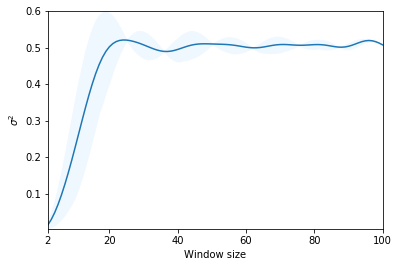

In [149]:
ex1_treino.plot_Var_Spectra(conf_region=[25,75])

In [154]:
t1 = np.arange(1,101)

sinal1 = np.sin(t1/4)
sinal1_2 = []
ex1_teste = []

ex1_treino = spectra(sinal1)
ex1_treino.calc_Var_Spectra()

for i in range(10):
        
    sinal1_2.append(sinal1+i*0.1*np.random.rand(sinal1.size))
    ex1_teste.append(spectra(sinal1_2[i]))
    ex1_teste[i].calc_Var_Spectra('sliding')

fig, axarr = plt.subplots(1,2,figsize=(10,6))
plt.close()

def animate(i):
    
    axarr[0].clear()
    axarr[0].set_title('Simulated signal')
    axarr[0].set_xlabel('t')
    axarr[1].clear()
    axarr[1].set_title('Variance spectra')
    axarr[0].plot(t1,sinal1_2[i])
    axarr[0].set_prop_cycle(None)
    
    axarr[0].set_xlim(0,100)
    axarr[0].set_ylim(-1,2)
    axarr[1].set_xlim(2,100)
    axarr[1].set_ylim(0,.8)
        
    axarr[1].plot(np.arange(2,ex1_teste[i].spctr_size['sliding']),
                 ex1_teste[i].var_spctr['sliding'][50][2:])
    
    axarr[1].fill_between(np.arange(2,ex1_treino.spctr_size['sliding']),
                          ex1_treino.var_spctr['sliding'][25][2:].squeeze(),
                          ex1_treino.var_spctr['sliding'][75][2:].squeeze(),
                          color='aliceblue');  
    
    fig.tight_layout()
    fig.subplots_adjust(top=0.9)
    fig.suptitle('Example 1')

    return axarr

anim1 = animation.FuncAnimation(fig, animate, frames=10, interval=300, blit=False)

In [155]:
HTML(anim1.to_html5_video())

## Referência

[Thiago Feital e José Carlos Pinto - Use of variance spectra for in-line validation of process measurements in continuous processes - The Canadian Journal of Chemical Engineering - 2015. DOI: 10.1002/cjce.22219.](http://onlinelibrary.wiley.com/doi/10.1002/cjce.22219/abstract)